#### The SST-2 dataset is part of the GLUE benchmark and is commonly used to evaluate the sentiment analysis capabilities of pretrained language models.

#### The original BERT base model on SST-2 task get 93.5% accuracy.
https://arxiv.org/abs/1810.04805

#### Method:

In this study, we conducted a controlled comparison by training the model on datasets of varying sizes: 1,000, 8,000, and 56,000 samples. To ensure a fair evaluation, we maintained a balanced class distribution across the training, validation, and test sets. Importantly, the test set remained identical across all training configurations, allowing for a consistent and reliable assessment of model generalization. Only the size of the training data was varied, while the model architecture, training hyperparameters, and evaluation protocol were held constant throughout the experiments.

#### Dataset Label Distribution

| Dataset       | Total Samples | Label 0 Count | Label 1 Count |
|---------------|----------------|----------------|----------------|
| Train (1k)    | 1000           | 500           | 500           |
| Train (8k)    | 8000           | 4000          | 4000          |
| Train (56k)   | 56000          | 28000          | 28000          |
| Validation    | 1000           | 500            | 500            |
| Test          | 872            | 428            | 444            |


#### Mount Google Drive to access local directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Install neccesary packages

In [ ]:
!pip install -U datasets # Install the Hugging Face `datasets` library

In [ ]:
!pip install -q -U transformers peft accelerate bitsandbytes
from datasets import load_dataset, concatenate_datasets, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import get_peft_model, LoraConfig, TaskType, PeftModel
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from collections import Counter
import torch
from transformers import EarlyStoppingCallback
import os
from transformers import Trainer
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

#### Load the dataset. Here, we take the GLUE SST2 dataset to evaluate the performaence of the model on a classification task.

In [ ]:
dataset = load_dataset("glue", "sst2")
print(dataset.shape)

{'train': (67349, 3), 'validation': (872, 3), 'test': (1821, 3)}


In [ ]:
dataset["test"].shape
dataset["test"][0:5]

{'sentence': ['uneasy mishmash of styles and genres .',
  "this film 's relationship to actual tension is the same as what christmas-tree flocking in a spray can is to actual snow : a poor -- if durable -- imitation .",
  'by the end of no such thing the audience , like beatrice , has a watchful affection for the monster .',
  'director rob marshall went out gunning to make a great one .',
  'lathan and diggs have considerable personal charm , and their screen rapport makes the old story seem new .'],
 'label': [-1, -1, -1, -1, -1],
 'idx': [0, 1, 2, 3, 4]}

In [ ]:
# Select the balanced training data and validation data
# Step 1: Separate positive and negative samples
pos_samples = dataset["train"].filter(lambda x: x["label"] == 1)
neg_samples = dataset["train"].filter(lambda x: x["label"] == 0)
print("training data positive number", pos_samples.shape)
print("training data negative number", neg_samples.shape)

# Step 2: Shuffle
pos_samples = pos_samples.shuffle(seed=42)
neg_samples = neg_samples.shuffle(seed=42)

# Step 3: Create balanced splits
n_train_each = 28000  # 28000 pos + 28000 neg = 56000
n_val_each = 500     # 500 pos + 500 neg = 1000

# Select training data and validation data
train_data = concatenate_datasets([
    pos_samples.select(range(n_train_each)),
    neg_samples.select(range(n_train_each))
])
val_data = concatenate_datasets([
    pos_samples.select(range(n_train_each, n_train_each + n_val_each)),
    neg_samples.select(range(n_train_each, n_train_each + n_val_each))
])

# Final test: use dataset["validation"] to be the test data
test_data = dataset["validation"]

# Combine into a DatasetDict and shuffle splits
custom_dataset = DatasetDict({
    "train": train_data.shuffle(seed=42),
    "validation": val_data.shuffle(seed=42),
    "test": test_data
})

training data positive number (37569, 3)
training data negative number (29780, 3)


In [ ]:
# View combined dataset structure and count labels
custom_dataset.shape
custom_dataset["train"][0:5]

train_labels = custom_dataset["train"]["label"]
val_labels = custom_dataset["validation"]["label"]
test_labels = custom_dataset["test"]["label"]

print("Train Label Counts:", Counter(train_labels))
print("Validation Label Counts:", Counter(val_labels))
print("Test Label Counts:", Counter(test_labels))

Train Label Counts: Counter({0: 28000, 1: 28000})
Validation Label Counts: Counter({0: 500, 1: 500})
Test Label Counts: Counter({1: 444, 0: 428})


In [ ]:
# Load the model tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Apply tokenizer to the dataset
def tokenize(example):
    return tokenizer(example["sentence"], padding="max_length", truncation=True)

# Map the tokenizer to the dataset in batch
encoded = custom_dataset.map(tokenize, batched=True)
# Convert the specific columns of the encoded data to torch tensors
encoded.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
# Create the directory to save the model weight and checkpoint
working_dir = '/content/drive/MyDrive/DL_practice/PEFT Lora/classification work with lora'
output_directory = os.path.join(working_dir, "peft_lab_outputs")

In [ ]:
class TrainerWithTrainMetrics(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.train_preds = []
        self.train_labels = []

    def training_step(self, model, inputs, num_steps):  # For each batch
        loss = super().training_step(model, inputs, num_steps)

        # Forward pass on training data (in eval mode) to collect predictions
        model.eval()
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            labels = inputs["labels"]

        self.train_preds.extend(preds.detach().cpu().numpy())
        self.train_labels.extend(labels.detach().cpu().numpy())
        model.train()

        return loss

    def on_epoch_end(self): # For each epoch
        if self.train_preds and self.train_labels:
            acc = accuracy_score(self.train_labels, self.train_preds)
            print(f"\n[Training Accuracy at epoch end]: {acc:.4f}")
            metrics = {"train_accuracy": acc}
            self.log(metrics) # Tell the Trainer to track this number
            self.state.log_history.append(metrics) # Append the result to the output csv
            self.train_preds.clear() # Clears the lists to start fresh for the next epoch
            self.train_labels.clear() # Clears the lists to start fresh for the next epoch


In [ ]:
base_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS,
)

model = get_peft_model(base_model, lora_config)
print(model.print_trainable_parameters())

training_args = TrainingArguments(
    output_dir=output_directory,
    logging_dir=os.path.join(working_dir, "logs"),             # where to save logs
    logging_strategy="epoch",        # log once per epoch
    eval_strategy="epoch",     # evaluate once per epoch
    save_strategy="epoch",           # save best model each epoch
    load_best_model_at_end=True,
    report_to="none",                # disable wandb/huggingface hub
    # auto_find_batch_size=True, # Find a correct batch size that fits the size of Data.
    learning_rate= 5e-4, # Higher learning rate than full fine-tuning.
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=1)
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc
    }

trainer = TrainerWithTrainMetrics(
    model=model,
    args=training_args,
    train_dataset=encoded["train"],
    eval_dataset=encoded["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-76-3658221776>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `TrainerWithTrainMetrics.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 296,450 || all params: 109,780,228 || trainable%: 0.2700
None


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.266700,0.201562,0.924000
2,0.187200,0.171617,0.935000
3,0.153600,0.174861,0.943000
4,0.130600,0.183409,0.944000


TrainOutput(global_step=7000, training_loss=0.18450872148786274, metrics={'train_runtime': 4379.313, 'train_samples_per_second': 63.937, 'train_steps_per_second': 1.998, 'total_flos': 5.914087194624e+16, 'train_loss': 0.18450872148786274, 'epoch': 4.0})

In [ ]:
# Save the model
model_path = os.path.join(output_directory, f"data_1000_lora")

trainer.model.save_pretrained(model_path)

log_history = trainer.state.log_history
log_df = pd.DataFrame(log_history)
log_df.to_csv(working_dir + "/training_log.csv", index=False)

In [ ]:
# Load the Model
loaded_model = PeftModel.from_pretrained(base_model,
                                        model_path,
                                        is_trainable=False)

/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'recall': recall,
        'precision': precision
    }

trainer = Trainer(
    model=loaded_model,
    args=training_args,
    train_dataset=encoded["train"],
    eval_dataset=encoded["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

<ipython-input-82-3757751598>:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
results = trainer.evaluate()
print(f"Accuracy: {results['eval_accuracy']:.4f}")
print(f"Recall:   {results['eval_recall']:.4f}")
print(f"F1 Score: {results['eval_f1']:.4f}")
print(f"Precision:{results['eval_precision']:.4f}")

Accuracy: 0.9350
Recall:   0.9260
F1 Score: 0.9344
Precision:0.9430


In [ ]:
print(results)

{'eval_loss': 0.17161670327186584, 'eval_model_preparation_time': 0.0053, 'eval_accuracy': 0.935, 'eval_f1': 0.934409687184662, 'eval_recall': 0.926, 'eval_precision': 0.9429735234215886, 'eval_runtime': 6.2042, 'eval_samples_per_second': 161.181, 'eval_steps_per_second': 5.158}


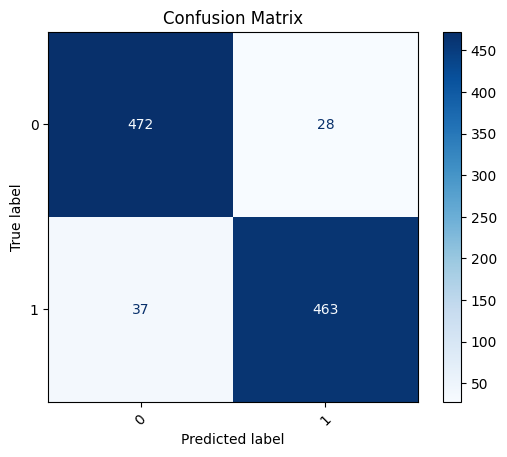

Total Samples: 1000


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

predictions_output = trainer.predict(encoded["test"])
logits = predictions_output.predictions
labels = predictions_output.label_ids
preds = np.argmax(logits, axis=-1)

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

Sample = len(encoded["validation"])
print(f"Total Samples: {Sample}")

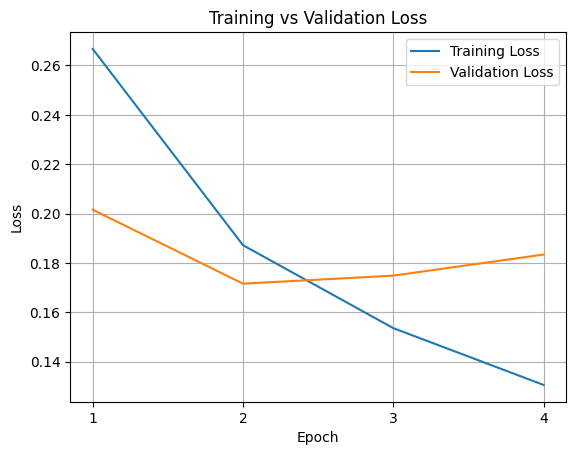

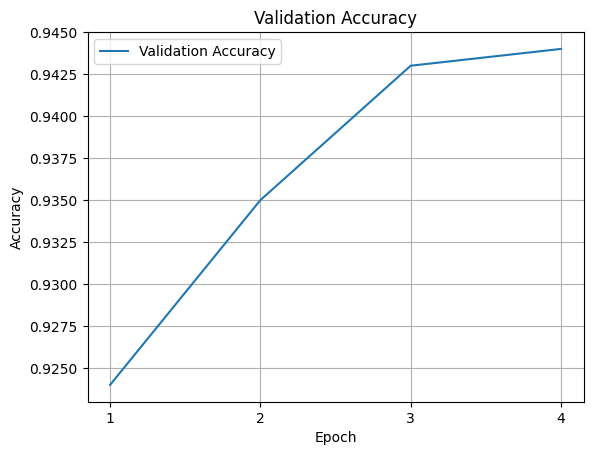

In [ ]:
import matplotlib.pyplot as plt

df = pd.read_csv(working_dir + "/training_log.csv")

train_loss = df[df["loss"].notna()][["epoch", "loss"]].drop_duplicates("epoch")

evaluation_loss = df[df["eval_loss"].notna()][["epoch", "eval_loss", "eval_accuracy"]].drop_duplicates("epoch")

merged_df = pd.merge(train_loss, evaluation_loss, on="epoch", how="inner")

plt.plot(merged_df["epoch"], merged_df["loss"], label="Training Loss")
plt.plot(merged_df["epoch"], merged_df["eval_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(ticks=merged_df["epoch"], labels=merged_df["epoch"].astype(int))  # show only integer epochs
plt.legend()
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.savefig(working_dir + "/loss.pdf")
plt.show()

if "eval_accuracy" in merged_df.columns:
    plt.plot(merged_df["epoch"], merged_df["eval_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.xticks(ticks=merged_df["epoch"], labels=merged_df["epoch"].astype(int))
    plt.legend()
    plt.title("Validation Accuracy")
    plt.grid(True)
    plt.savefig(working_dir + "/acc.pdf")
    plt.show()

#### Discussion

| Training Data Size | Loss  | Accuracy | F1-score |
|--------------------|-------|----------|----------|
| 1000               | 0.364 | 0.852    | 0.853    |
| 8000               | 0.247 | 0.896    | 0.898    |
| 56000              | 0.234 | 0.915    | 0.916    |

The table above summarizes the model performance on the test set using different amounts of training data. As the training data size increases from 1,000 to 56,000, both the loss and performance metrics improve consistently. Specifically, the test accuracy rises from 87.3% to 93.5%, and the F1-score improves from 0.875 to 0.934. This indicates that increasing the training data significantly enhances the model's ability to generalize, resulting in more accurate and balanced predictions.

Since the model architecture and evaluation dataset remain constant across all experiments, the inference time (~6.2 seconds) is effectively unchanged and thus excluded from the comparison. The focus is instead placed on how data scale influences classification performance.

According to the original BERT paper, the BERT<sub>BASE</sub> model achieves 93.5% accuracy on the SST-2 task using full fine-tuning. In our experiments, we reach the same level of accuracy using LoRA-based parameter-efficient fine-tuning, while updating only 0.27% of the model's parameters. This demonstrates that LoRA can retain competitive performance with significantly reduced training cost and memory footprint.

